<a href="https://colab.research.google.com/github/YuvalHoffman/Music-Genre-Classification-using-Transformers/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Music Genre Classiffication**
by Yuval Hoffman and Roee Hadar.


The project focuses on developing an advanced audio classification model using the GTZAN dataset, a benchmark in music genre classification. The model aims to accurately classify audio samples into various music genres.

Beginning with data preprocessing, the pipeline utilizes a pre-trained feature extractor to extract relevant audio features, ensuring robust representation of the input data. To enhance model generalization and performance, diverse augmentation techniques such as white noise addition, pitch shifting, and bandstop filtering are employed, enriching the dataset with variations. Further explanation of the Augmentations employed is provided in the "Augmentations" section.

The core of the project lies in fine-tuning a pre-trained audio classification model, specifically tailored for the GTZAN dataset. Through iterative training and evaluation cycles, the model learns to effectively classify audio samples, optimizing for accuracy and robustness. The fine-tuning process involves adjusting the model's parameters to better fit the characteristics of the dataset, thereby enhancing its ability to capture intricate patterns and nuances in audio data.



---



The model we used is DistilHubert, which is provided in this [site](https://www.geeksforgeeks.org/music-genre-classification-using-transformers/), has been selected after numerous attempts with different models, such as HuBERT, word2vec and more.
The core of the project lies both in the fine tuning and in the Augmentations applied to the data, in order to achieve higher success rates.

---

Install Libraries

In [ ]:
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install evaluate
!pip install pydub
!pip install audiomentations
!pip install torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
!pip show evaluate


Name: evaluate
Version: 0.4.1
Summary: HuggingFace community-driven open-source library of evaluation
Home-page: https://github.com/huggingface/evaluate
Author: HuggingFace Inc.
Author-email: leandro@huggingface.co
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: datasets, dill, fsspec, huggingface-hub, multiprocess, numpy, packaging, pandas, requests, responses, tqdm, xxhash
Required-by: 


In [ ]:
from datasets import load_dataset, Audio
import numpy as np
from transformers import pipeline, AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
import evaluate
import torchaudio
from torchaudio.transforms import TimeMasking, FrequencyMasking, Vol
from datasets import DatasetDict
from pydub import AudioSegment
import torch
from torch.utils.data import Dataset
import random
import librosa
import scipy.signal as signal

**READ THIS:** the files are located at:

https://drive.google.com/drive/folders/1Pv3h1QQFFp8JTPL47pLVwfVbNL6teqhb?usp=sharing

download the folder into your drive at:

folder_path_orignal = '/content/drive/My Drive/Deep Learning\Project'

You might want to use:

import os
os.makedirs(folder_path_orignal, exist_ok=True)

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Transformers version: 4.38.2
Mounted at /content/drive



The GTZAN dataset is a widely used collection of audio clips commonly employed for music genre classification tasks. Comprising 1,000 audio tracks, each spanning 30 seconds, it encompasses 10 distinct music genres, with 100 tracks per genre. The dataset serves as a benchmark for evaluating the performance of machine learning algorithms in genre classification. Its genres range from classical and jazz to rock and hip-hop, offering a diverse selection for training and testing models.

This part loads the GTZAN model and splits the data into training set and testing set, which acts as a validtion set

In [ ]:
gtzan = load_dataset("marsyas/gtzan", "all")
gtzan = gtzan["train"].train_test_split(seed=42, shuffle=True, test_size=0.1, train_size=0.4)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for marsyas/gtzan contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/marsyas/gtzan
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.war

Generating train split: 0 examples [00:00, ? examples/s]

# Choose the Model and pre pre-processing the Data

The "ntu-spml/distilhubert" model is a compact and efficient variant of the Hubert architecture, developed by Nanyang Technological University's Speech Processing and Machine Learning (NTU-SPML) team. Employing distillation techniques, it retains essential performance characteristics while reducing computational complexity and memory footprint. This model is tailored for speech processing tasks, offering versatility and resource efficiency suitable for deployment in diverse environments, including mobile devices and edge computing platforms.

In [ ]:
# Choose the model identifier
model_id = "ntu-spml/distilhubert"
folder_path_r = '/content/drive/My Drive/Deep Learning/Project/ROEE'

# Load the feature extractor for the specified model
feature_extractor = AutoFeatureExtractor.from_pretrained(
    folder_path_r,  # Load the pre-trained feature extractor (load a model we all ready fine tune)
    do_normalize=True,  # Normalize the input (common practice)
    return_attention_mask=True  # Return the attention mask (important for some models)
)

# Get the sampling rate supported by the feature extractor
sampling_rate = feature_extractor.sampling_rate

# Cast the 'audio' column of your gtzan dataset to Audio format
gtzan = gtzan.cast_column("audio", Audio(sampling_rate=sampling_rate))

# Get the first audio sample from the training set of gtzan dataset
sample = gtzan["train"][0]["audio"]

# Extract features from the audio sample
inputs = feature_extractor(
    sample["array"],  # Input the audio data array
    sampling_rate=sample["sampling_rate"]  # Ensure correct sampling rate
)

# Define the maximum audio duration to be processed (in seconds)
max_duration = 20.0

**Original Preprocessing function**

This function serves as a crucial preprocessing step for audio data, preparing it for consumption by a pre-trained model. By extracting audio arrays from the input dictionary, it formats them to meet the expectations of the feature extractor. With careful consideration of parameters such as sampling rate and max. duration, the function ensures compatibility with the model's requirements. Ultimately, it yields a dictionary containing preprocessed audio features, primed for seamless integration into the model's classification pipeline.

In [ ]:
def preprocess_function(examples):
  """
  Preprocesses audio data for the pre-trained model.

  This function takes a dictionary `examples` containing audio samples and
  transforms them into the format expected by the feature extractor.

  Args:
    examples: A dictionary containing audio data. It's expected to have an
              "audio" key with a list of audio samples as dictionaries.
              Each audio sample dictionary should have an "array" key containing
              the raw audio data.

  Returns:
    A dictionary containing the preprocessed audio features ready for
    consumption by the model. This dictionary will have the same keys as
    the output of the feature_extractor function.
  """

  # Extract audio arrays from the examples dictionary
  audio_arrays = [x["array"] for x in examples["audio"]]

  # Prepare the arguments for the feature extractor
  inputs = feature_extractor(
      audio_arrays,                                                    # List of audio arrays
      sampling_rate=feature_extractor.sampling_rate,                   # Use the model's supported rate
      max_length=int(feature_extractor.sampling_rate * max_duration),  # Set max length based on duration
      truncation=True,                                                 # Truncate if audio exceeds max_length
      return_attention_mask=True,                                      # Return attention mask for some models
  )

  # Return the preprocessed features
  return inputs

## Fine-Tuning and Evalutaion of the Based Model


This segment orchestrates the application of the preprocess_function across the GTZAN dataset, enabling efficient preprocessing of audio data in batch mode. By invoking the map function with specified parameters, it iterates through the dataset, applying the preprocessing function to each sample. Additionally, it removes unnecessary columns such as "audio" and "file" to streamline the dataset's structure.

In [ ]:
gtzan_encoded = gtzan.map(
	preprocess_function,
	remove_columns=["audio", "file"],
	batched=True,
	batch_size=10,
	num_proc=1,
)

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]


This code section manages label information for the GTZAN dataset. It renames the label column for clarity, establishes functions to convert between integer and string labels, creates dictionaries for mapping between integer and readable labels, and prints a sample of label mappings for illustration.

In [ ]:
# Rename the label column for clarity
gtzan_encoded = gtzan_encoded.rename_column("genre", "label")

# Function to convert integer label to string label (potentially from gtzan library)
id2label_fn = gtzan["train"].features["genre"].int2str

# Create a dictionary mapping integer labels (as strings) to human-readable labels
id2label = {
  str(i): id2label_fn(i)  # Convert integer label (i) to string label using id2label_fn
  for i in range(len(gtzan_encoded["train"].features["label"].names))  # Iterate through all possible labels
}

# Create a dictionary mapping string labels to their corresponding integer labels (inverse of id2label)
label2id = {v: k for k, v in id2label.items()}

# Print a sample of the label mappings
print("Example label mapping:")
print(f"Integer label 0: {id2label['0']}")  # Print the string label for integer label 0


Example label mapping:
Integer label 0: blues



This section of the code orchestrates several crucial steps in model initialization and training configuration:

1. Label Counting and Model Loading:
* Counts the number of unique labels from the id2label dictionary, essential for setting the number of output labels in the model.
* Loads a pre-trained audio classification model (AutoModelForAudioClassification) for fine-tuning. Parameters include the model identifier, number of output labels, label mappings, and interpretation dictionaries.


2. Model Architecture Inspection:

* Prints a detailed summary of the model's architecture, providing insight into its structure and complexity.
* Computes and prints the total number of trainable parameters in the model, crucial for understanding its computational footprint.

3. Training Configuration:

* Extracts the model name from the model identifier for reference and naming purposes.
* Defines various training arguments for the Trainer object, including output directory, evaluation and save strategies, learning rate, batch sizes, number of epochs, gradient accumulation steps, and more.

In [ ]:
# Count the number of labels from the id2label dictionary
num_labels = len(id2label)

# Load the pre-trained model for audio classification for fine-tuning
model = AutoModelForAudioClassification.from_pretrained(
    folder_path_r,  # Load the specified pre-trained model identifier **We allready trained**
    num_labels=num_labels,  # Set the number of output labels based on the dataset
    label2id=label2id,  # Provide a dictionary mapping string labels to integer labels (for model output)
    id2label=id2label,  # Provide a dictionary mapping integer labels to human-readable labels (for interpretation)
)

# Print the model architecture (might be a long string)
print("Model Architecture:")
print(model)  # This will print the detailed model architecture

# Print the total number of parameters in the model
print("\nTotal Trainable Parameters:")
print(sum(p.numel() for p in model.parameters()))  # Count parameters of all modules


# Extract the model name from the model identifier
model_name = model_id.split("/")[-1]

# Define the batch size for training (number of samples processed together)
batch_size = 10

# Define the number of gradient accumulation steps (can improve memory usage)
gradient_accumulation_steps = 1

# Define the number of epochs for training
num_train_epochs = 50

# Define training arguments for the Trainer object
training_args = TrainingArguments(
    output_dir=f"{model_name}-Music classification Finetuned",  # Output directory name
    evaluation_strategy="epoch",  															# Evaluate after each epoch
    save_strategy="epoch",  																		# Save model checkpoints after each epoch
    learning_rate=5e-5,  																				# Set the learning rate for the optimizer
    per_device_train_batch_size=batch_size, 									  # Batch size per device (if using multiple GPUs)
    gradient_accumulation_steps=gradient_accumulation_steps,    # Gradient accumulation steps
    per_device_eval_batch_size=batch_size,  										# Batch size per device for evaluation
    num_train_epochs=num_train_epochs,  												# Number of training epochs
    warmup_ratio=0.1,  																					# Warmup ratio for the learning rate scheduler
    logging_steps=1,  																					# Log training information every step
    load_best_model_at_end=True,  															# Load the best model based on the specified metric
    metric_for_best_model="accuracy",  													# Define the metric to monitor for best model selection to accuracy.
    fp16=False,  																								# Disable mixed precision training (might cause instability)
    )

Model Architecture:
HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPosi


This segment configures the evaluation setup and initiates model training. It starts by loading the 'accuracy' metric and defining a function to compute it based on model predictions and ground truth labels. Then, it initializes the Trainer object with the pre-trained model, training arguments, datasets, tokenizer, and the accuracy metric computation function for evaluation. Finally, it begins training the model using the initialized Trainer object.

In [ ]:
# Load the 'accuracy' metric from the evaluate library
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  """
  This function computes the accuracy metric for the model's predictions.

  Args:
      eval_pred: A dictionary containing the evaluation predictions.
          - predictions: A NumPy array of the model's predicted class labels.
          - label_ids: A NumPy array of the ground truth labels.

  Returns:
      A dictionary containing the computed metric (accuracy in this case).
  """

  # Get the predicted class labels (argmax across prediction probabilities)
  predictions = np.argmax(eval_pred.predictions, axis=1)

  # Compute the accuracy metric using the 'evaluate' library
  return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Initialize the Trainer object for training and evaluation
trainer = Trainer(
    model,
    training_args,
    train_dataset=gtzan_encoded["train"],
    eval_dataset=gtzan_encoded["test"],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
# Train the model using the Trainer object
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.177400,1.122959,0.670000
2,0.784000,0.987597,0.720000
3,0.693900,0.937552,0.720000
4,0.201300,0.878061,0.750000
5,0.215700,0.939414,0.700000
6,0.110700,0.833122,0.710000
7,0.076900,0.837253,0.780000
8,0.057600,0.875761,0.770000
9,0.039900,0.885682,0.780000
10,0.060700,0.871170,0.780000


TrainOutput(global_step=400, training_loss=0.39433434047736227, metrics={'train_runtime': 2228.1381, 'train_samples_per_second': 1.791, 'train_steps_per_second': 0.18, 'total_flos': 1.814950924416e+17, 'train_loss': 0.39433434047736227, 'epoch': 10.0})

This part save the received Original Model

In [ ]:
# Define the path to your desired folder
folder_path_orignal = '/content/drive/My Drive/Deep Learning/Project/Saved Original Model'

# Create the directory if it doesn't exist
import os
os.makedirs(folder_path_orignal, exist_ok=True)

# Save the model and feature extractor
model.save_pretrained(folder_path_orignal)

feature_extractor.save_pretrained(folder_path_orignal)

['/content/drive/My Drive/Deep Learning/Project/Saved Original Model/preprocessor_config.json']

In [ ]:
folder_path_orignal = '/content/drive/My Drive/Deep Learning/Project/Saved Original Model'



This part facilitates genre prediction of audio files using the trained model. It loads the model and feature extractor, creates a classification pipeline, and defines a function for prediction. Upon inputting the file path, it predicts the genre and prints the result with the prediction score.

In [ ]:
# Define the path to your desired folder
folder_path_r = '/content/drive/My Drive/Deep Learning/Project/ROEE'

# Load the model from the saved directory
loaded_model = AutoModelForAudioClassification.from_pretrained(folder_path_orignal)

# Load the feature extractor if needed
loaded_feature_extractor = AutoFeatureExtractor.from_pretrained(folder_path_orignal)

# Create the audio classification pipeline
pipe = pipeline("audio-classification", model=loaded_model, feature_extractor=loaded_feature_extractor)


def classify_audio(filepath):
	preds = pipe(filepath)
	outputs = {}
	for p in preds:
		outputs[p["label"]] = p["score"]
	return outputs


# Provide the input file path
input_file_path = input('Input:')

# Classify the audio file
output = classify_audio(input_file_path)

# Print the output genre
print("Predicted Genre:")
max_key = max(output, key=output.get)

print("The predicted genre is:", max_key)
print("The prediction score is:", output[max_key])

Input:/content/drive/MyDrive/Deep Learning/Project/sound-genre-blue.wav
Predicted Genre:
The predicted genre is: classical
The prediction score is: 0.5102788805961609


## Augmentations

As described above, following are the Augmentations deployed on our data and the explanation for the picking of each Augmentation:


*   White noise:
  *  The incorporation of white noise replicates common environmental conditions encountered during audio recording, such as ambient noise or microphone interference. By exposing the model to such perturbations, it learns to discern and prioritize signal over noise, thereby enhancing its robustness in handling real-world audio inputs with varying levels of background noise.
*   Pitch Scaling
  *  Pitch shifting introduces variations in the frequency content of audio signals, effectively altering the perceived pitch of the sound without distorting its temporal characteristics. This augmentation technique emulates natural fluctuations in vocal or instrumental tones, fostering the model's capacity to generalize across a spectrum of pitch variations. Consequently, the model becomes adept at recognizing semantic features irrespective of pitch, thereby enhancing its capacity for accurate classification across diverse audio samples.
*   BSF
  *   Bandstop filtering selectively attenuates specific frequency bands within the audio spectrum, effectively suppressing undesired frequency components while preserving relevant signal information. By systematically filtering out extraneous frequencies that may detract from the discriminative features within the audio signal, this augmentation method refines the model's ability to discern salient audio characteristics crucial for accurate classification. Consequently, the model becomes adept at discerning meaningful features while mitigating the influence of interference, thus bolstering its classification performance in challenging audio environments.




TODO: Do it for 20% of the Bandwidth at random frequencies  

In [ ]:
def bandstop_filter(audio_array, sampling_rate):
  """
  Applies a Butterworth bandstop filter to an audio array with random bandwidth.

  This function takes an audio array and its sampling rate and returns the filtered
  audio array with a random bandstop filter applied. The filter has a random center
  frequency and a bandwidth of 20% of the sampling rate.

  Args:
    audio_array: The raw audio data as a NumPy array.
    sampling_rate: The sampling rate of the audio data (in Hz).

  Returns:
    The audio array after applying a random Butterworth bandstop filter.
  """

  # Calculate the Nyquist frequency
  nyquist = 0.5 * sampling_rate  # Half of the sampling rate

  # Define the bandwidth as 20% of the Nyquist frequency
  bandwidth = 0.2 * nyquist

  # Generate random center frequency within the Nyquist limit
  center_freq = random.uniform(bandwidth, nyquist-bandwidth)  # random.uniform for continuous distribution

  # Calculate low and high cutoff frequencies based on center and bandwidth
  low_freq = center_freq - bandwidth / 2
  high_freq = center_freq + bandwidth / 2

  # Ensure frequencies are within Nyquist limit (clip if necessary)
  low_freq = max(0, low_freq)  # clip lower frequency to 0 (avoid negative values)
  high_freq = min(nyquist, high_freq)  # clip higher frequency to Nyquist

  # Normalize cutoff frequencies
  low = low_freq / nyquist
  high = high_freq / nyquist

  # Design the Butterworth bandstop filter (switch btype to 'stop')
  b, a = signal.butter(5, [low, high], btype='stop')  # Order 5, cutoff range, bandstop type

  # Apply the filter to the audio data
  filtered_audio_array = signal.filtfilt(b, a, audio_array)  # Apply forward-backward filtering

  # Return the filtered audio array
  return filtered_audio_array

Augmentation Preprocessing Data

In [ ]:
def preprocess_function_augmentation_noise(examples):
    """
    Preprocesses audio examples with optional augmentation based on the argument.

    Args:
        examples: A list of dictionaries containing audio data and other information.
        augmentation_type: A string specifying the type of augmentation to apply (optional).

    Returns:
        A dictionary containing the preprocessed audio features and attention mask.
    """

    audio_arrays = [x["array"] for x in examples["audio"]]
    augmented_audio_arrays = []
    augmentation_type = "noise"

    for ii, audio_array in enumerate(audio_arrays):
        # Apply augmentation based on the argument (if provided)
        if augmentation_type == "none":
            augmented_audio_array = audio_array  # No augmentation
        elif augmentation_type == "noise":
            # Add white noise
            noise = np.random.normal(scale=0.005, size=len(audio_array))
            augmented_audio_array = audio_array + noise
        elif augmentation_type == "pitch_shift":
            # Pitch shift
            pitch_shift_amount = np.random.uniform(low=-1, high=1)
            augmented_audio_array = librosa.effects.pitch_shift(
                audio_array,
                sr=sampling_rate,
                n_steps=pitch_shift_amount
            )
        elif augmentation_type == "bandstop":
            # Bandstop filter
            augmented_audio_array = bandstop_filter(audio_array, sampling_rate)
        else:
            raise ValueError(f"Unsupported augmentation type: {augmentation_type}")
        if ii%2 == 0:
          augmented_audio_arrays.append(audio_array)
        else:
          augmented_audio_arrays.append(augmented_audio_array)

    # Extract features (assuming 'feature_extractor' is defined)
    inputs = feature_extractor(
        augmented_audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [ ]:
def preprocess_function_augmentation_pitch_shift(examples):
    """
    Preprocesses audio examples with optional augmentation based on the argument.

    Args:
        examples: A list of dictionaries containing audio data and other information.
        augmentation_type: A string specifying the type of augmentation to apply (optional).

    Returns:
        A dictionary containing the preprocessed audio features and attention mask.
    """

    audio_arrays = [x["array"] for x in examples["audio"]]
    augmented_audio_arrays = []
    augmentation_type = "pitch_shift"
    for ii, audio_array in enumerate(audio_arrays):
        # Apply augmentation based on the argument (if provided)
        if augmentation_type == "none":
            augmented_audio_array = audio_array  # No augmentation
        elif augmentation_type == "noise":
            # Add white noise
            noise = np.random.normal(scale=0.005, size=len(audio_array))
            augmented_audio_array = audio_array + noise
        elif augmentation_type == "pitch_shift":
            # Pitch shift
            pitch_shift_amount = np.random.uniform(low=-1, high=1)
            augmented_audio_array = librosa.effects.pitch_shift(
                audio_array,
                sr=sampling_rate,
                n_steps=pitch_shift_amount
            )
        elif augmentation_type == "bandstop":
            # Bandstop filter
            augmented_audio_array = bandstop_filter(audio_array, sampling_rate)
        else:
            raise ValueError(f"Unsupported augmentation type: {augmentation_type}")

        if ii%2 == 0:
          augmented_audio_arrays.append(audio_array)
        else:
          augmented_audio_arrays.append(augmented_audio_array)

    # Extract features (assuming 'feature_extractor' is defined)
    inputs = feature_extractor(
        augmented_audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

In [ ]:
def preprocess_function_augmentation_bandstop(examples):
    """
    Preprocesses audio examples with optional augmentation based on the argument.

    Args:
        examples: A list of dictionaries containing audio data and other information.
        augmentation_type: A string specifying the type of augmentation to apply (optional).

    Returns:
        A dictionary containing the preprocessed audio features and attention mask.
    """

    audio_arrays = [x["array"] for x in examples["audio"]]
    augmented_audio_arrays = []
    augmentation_type = "bandstop"
    for ii, audio_array in enumerate(audio_arrays):
        # Apply augmentation based on the argument (if provided)
        if augmentation_type == "none":
            augmented_audio_array = audio_array  # No augmentation
        elif augmentation_type == "noise":
            # Add white noise
            noise = np.random.normal(scale=0.005, size=len(audio_array))
            augmented_audio_array = audio_array + noise
        elif augmentation_type == "pitch_shift":
            # Pitch shift
            pitch_shift_amount = np.random.uniform(low=-1, high=1)
            augmented_audio_array = librosa.effects.pitch_shift(
                audio_array,
                sr=sampling_rate,
                n_steps=pitch_shift_amount
            )
        elif augmentation_type == "bandstop":
            # Bandstop filter
            augmented_audio_array = bandstop_filter(audio_array, sampling_rate)
        else:
            raise ValueError(f"Unsupported augmentation type: {augmentation_type}")

        if ii%2 == 0:
          augmented_audio_arrays.append(audio_array)
        else:
          augmented_audio_arrays.append(augmented_audio_array)

    # Extract features (assuming 'feature_extractor' is defined)
    inputs = feature_extractor(
        augmented_audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=int(feature_extractor.sampling_rate * max_duration),
        truncation=True,
        return_attention_mask=True,
    )
    return inputs

Encoding of the Dataset using the three augmentation.

In [ ]:
gtzan_encoded_noise = gtzan.map(
    preprocess_function_augmentation_noise,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=batch_size,
    num_proc=1,
)

gtzan_encoded_pitch_shift = gtzan.map(
    preprocess_function_augmentation_pitch_shift,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=batch_size,
    num_proc=1,
)

gtzan_encoded_bandstop = gtzan.map(
    preprocess_function_augmentation_bandstop,
    remove_columns=["audio", "file"],
    batched=True,
    batch_size=batch_size,
    num_proc=1,

)

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

TODO: Improve the way it look.

### White Noise

In [ ]:
"""
This script processes label data from an audio classification dataset, likely
using the gtzan library. It renames a label column, creates dictionaries for
mapping between integer and string labels, and provides an example of their usage.
"""

# Rename the label column for clarity
gtzan_encoded_noise = gtzan_encoded_noise.rename_column("genre", "label")

# TODO: check what is un-necceary below:

# Function to convert integer label to string label (potentially from gtzan library)
id2label_fn = gtzan["train"].features["genre"].int2str

# Create a dictionary mapping integer labels (as strings) to human-readable labels
id2label = {
  str(i): id2label_fn(i)  # Convert integer label (i) to string label using id2label_fn
  for i in range(len(gtzan_encoded_noise["train"].features["label"].names))  # Iterate through all possible labels
}

# Create a dictionary mapping string labels to their corresponding integer labels (inverse of id2label)
label2id = {v: k for k, v in id2label.items()}

# Print a sample of the label mappings
print("Example label mapping:")
print(f"Integer label 0: {id2label['0']}")  # Print the string label for integer label 0
# todo-------


Example label mapping:
Integer label 0: blues


Classification Model

In [ ]:
# Count the number of labels from the id2label dictionary
num_labels = len(id2label)

# Load the pre-trained model for audio classification for fine-tuning

# TODO change it to model we all ready trained.

model = AutoModelForAudioClassification.from_pretrained(
    folder_path_orignal,  # Load the specified pre-trained model identifier
    num_labels=num_labels,  # Set the number of output labels based on the dataset
    label2id=label2id,  # Provide a dictionary mapping string labels to integer labels (for model output)
    id2label=id2label,  # Provide a dictionary mapping integer labels to human-readable labels (for interpretation)
)

# Print the model architecture (might be a long string)
print("Model Architecture:")
print(model)  # This will print the detailed model architecture

# Print the total number of parameters in the model
print("\nTotal Trainable Parameters:")
print(sum(p.numel() for p in model.parameters()))  # Count parameters of all modules


# Extract the model name from the model identifier
model_name = model_id.split("/")[-1]

# Define the batch size for training (number of samples processed together)
batch_size = 8

# Define the number of gradient accumulation steps (can improve memory usage)
gradient_accumulation_steps = 1

# Define the number of epochs for training
num_train_epochs = 4

# Define training arguments for the Trainer object
training_args = TrainingArguments(
    output_dir=f"{model_name}-Music classification Finetuned",  # Output directory name
    evaluation_strategy="epoch",  															# Evaluate after each epoch
    save_strategy="epoch",  																		# Save model checkpoints after each epoch
    learning_rate=5e-5,  																				# Set the learning rate for the optimizer
    per_device_train_batch_size=batch_size, 									  # Batch size per device (if using multiple GPUs)
    gradient_accumulation_steps=gradient_accumulation_steps,    # Gradient accumulation steps
    per_device_eval_batch_size=batch_size,  										# Batch size per device for evaluation
    num_train_epochs=num_train_epochs,  												# Number of training epochs
    warmup_ratio=0.1,  																					# Warmup ratio for the learning rate scheduler
    logging_steps=1,  																					# Log training information every step
    load_best_model_at_end=True,  															# Load the best model based on the specified metric
    metric_for_best_model="accuracy",  													# Define the metric to monitor for best model selection to accuracy.
    fp16=False,  																								# Disable mixed precision training (might cause instability)
)

Model Architecture:
HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPosi

In [ ]:

trainer = Trainer(
	model,
	training_args,
	train_dataset=gtzan_encoded_noise["train"],
	eval_dataset=gtzan_encoded["test"], #validation on orignal song!
	tokenizer=feature_extractor,
	compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.184300,0.939534,0.710000
2,0.030100,1.065976,0.750000
3,0.014400,1.167414,0.740000
4,0.013200,1.165970,0.730000


Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-50 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-150 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-200 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=200, training_loss=0.08610600227490067, metrics={'train_runtime': 894.7606, 'train_samples_per_second': 1.784, 'train_steps_per_second': 0.224, 'total_flos': 7.259803697664e+16, 'train_loss': 0.08610600227490067, 'epoch': 4.0})

Save the Model

In [ ]:
# Define the path to your desired folder
folder_path = '/content/drive/My Drive/Deep Learning/Project/Saved Model Noise'

# Create the directory if it doesn't exist
import os
os.makedirs(folder_path, exist_ok=True)

# Save the model and feature extractor
model.save_pretrained(folder_path)

feature_extractor.save_pretrained(folder_path)

['/content/drive/My Drive/Deep Learning/Project/Saved Model Noise/preprocessor_config.json']

In [ ]:
'''# Load the model from the saved directory
loaded_model = AutoModelForAudioClassification.from_pretrained(folder_path)

# Load the feature extractor if needed
loaded_feature_extractor = AutoFeatureExtractor.from_pretrained(folder_path)

# Create the audio classification pipeline
pipe = pipeline("audio-classification", model=loaded_model, feature_extractor=loaded_feature_extractor)


# Provide the input file path
input_file_path = input('Input:')

# Classify the audio file
output = classify_audio(input_file_path)

# Print the output genre
print("Predicted Genre:")
max_key = max(output, key=output.get)

print("The predicted genre is:", max_key)
print("The prediction score is:", output[max_key])
'''

'# Load the model from the saved directory\nloaded_model = AutoModelForAudioClassification.from_pretrained(folder_path)\n\n# Load the feature extractor if needed\nloaded_feature_extractor = AutoFeatureExtractor.from_pretrained(folder_path)\n\n# Create the audio classification pipeline\npipe = pipeline("audio-classification", model=loaded_model, feature_extractor=loaded_feature_extractor)\n\n\n# Provide the input file path\ninput_file_path = input(\'Input:\')\n\n# Classify the audio file\noutput = classify_audio(input_file_path)\n\n# Print the output genre\nprint("Predicted Genre:")\nmax_key = max(output, key=output.get)\n\nprint("The predicted genre is:", max_key)\nprint("The prediction score is:", output[max_key])\n'

### Pitch Shifting

In [ ]:
"""
This script processes label data from an audio classification dataset, likely
using the gtzan library. It renames a label column, creates dictionaries for
mapping between integer and string labels, and provides an example of their usage.
"""

# Rename the label column for clarity
gtzan_encoded_pitch_shift = gtzan_encoded_pitch_shift.rename_column("genre", "label")

# TODO: check what is un-necceary below:

# Function to convert integer label to string label (potentially from gtzan library)
id2label_fn = gtzan["train"].features["genre"].int2str

# Create a dictionary mapping integer labels (as strings) to human-readable labels
id2label = {
  str(i): id2label_fn(i)  # Convert integer label (i) to string label using id2label_fn
  for i in range(len(gtzan_encoded["train"].features["label"].names))  # Iterate through all possible labels
}

# Create a dictionary mapping string labels to their corresponding integer labels (inverse of id2label)
label2id = {v: k for k, v in id2label.items()}

# Print a sample of the label mappings
print("Example label mapping:")
print(f"Integer label 0: {id2label['0']}")  # Print the string label for integer label 0
# todo-------

Example label mapping:
Integer label 0: blues


In [ ]:
# Count the number of labels from the id2label dictionary
num_labels = len(id2label)

# Load the pre-trained model for audio classification for fine-tuning

# TODO change it to model we all ready trained.

model = AutoModelForAudioClassification.from_pretrained(
    folder_path_orignal,  # Load the specified pre-trained model identifier
    num_labels=num_labels,  # Set the number of output labels based on the dataset
    label2id=label2id,  # Provide a dictionary mapping string labels to integer labels (for model output)
    id2label=id2label,  # Provide a dictionary mapping integer labels to human-readable labels (for interpretation)
)

# Print the model architecture (might be a long string)
print("Model Architecture:")
print(model)  # This will print the detailed model architecture

# Print the total number of parameters in the model
print("\nTotal Trainable Parameters:")
print(sum(p.numel() for p in model.parameters()))  # Count parameters of all modules


# Extract the model name from the model identifier
model_name = model_id.split("/")[-1]

# Define the batch size for training (number of samples processed together)
batch_size = 8

# Define the number of gradient accumulation steps (can improve memory usage)
gradient_accumulation_steps = 1

# Define the number of epochs for training
num_train_epochs = 4

# Define training arguments for the Trainer object
training_args = TrainingArguments(
    output_dir=f"{model_name}-Music classification Finetuned",  # Output directory name
    evaluation_strategy="epoch",  															# Evaluate after each epoch
    save_strategy="epoch",  																		# Save model checkpoints after each epoch
    learning_rate=5e-5,  																				# Set the learning rate for the optimizer
    per_device_train_batch_size=batch_size, 									  # Batch size per device (if using multiple GPUs)
    gradient_accumulation_steps=gradient_accumulation_steps,    # Gradient accumulation steps
    per_device_eval_batch_size=batch_size,  										# Batch size per device for evaluation
    num_train_epochs=num_train_epochs,  												# Number of training epochs
    warmup_ratio=0.1,  																					# Warmup ratio for the learning rate scheduler
    logging_steps=1,  																					# Log training information every step
    load_best_model_at_end=True,  															# Load the best model based on the specified metric
    metric_for_best_model="accuracy",  													# Define the metric to monitor for best model selection to accuracy.
    fp16=False,  																								# Disable mixed precision training (might cause instability)
)

Model Architecture:
HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPosi

In [ ]:
trainer = Trainer(
	model,
	training_args,
	train_dataset=gtzan_encoded_pitch_shift["train"],
	eval_dataset=gtzan_encoded["test"], #validation on orignal song!
	tokenizer=feature_extractor,
	compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.451600,1.118160,0.630000
2,0.159100,1.008989,0.670000
3,0.259200,0.973687,0.710000
4,0.035700,0.868472,0.750000


Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-50 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-150 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-200 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=200, training_loss=0.373771706353873, metrics={'train_runtime': 924.6618, 'train_samples_per_second': 1.726, 'train_steps_per_second': 0.216, 'total_flos': 7.259803697664e+16, 'train_loss': 0.373771706353873, 'epoch': 4.0})

Save the Model

In [ ]:
# Define the path to your desired folder
folder_path = '/content/drive/My Drive/Deep Learning/Project/Saved Model Pitch Shift'

# Create the directory if it doesn't exist
os.makedirs(folder_path, exist_ok=True)

# Save the model and feature extractor
model.save_pretrained(folder_path)

feature_extractor.save_pretrained(folder_path)

['/content/drive/My Drive/Deep Learning/Project/Saved Model Pitch Shift/preprocessor_config.json']

### Band-Stop Filter

In [ ]:
"""
This script processes label data from an audio classification dataset, likely
using the gtzan library. It renames a label column, creates dictionaries for
mapping between integer and string labels, and provides an example of their usage.
"""

# Rename the label column for clarity
gtzan_encoded_bandstop = gtzan_encoded_bandstop.rename_column("genre", "label")

# TODO: check what is un-necceary below:

# Function to convert integer label to string label (potentially from gtzan library)
id2label_fn = gtzan["train"].features["genre"].int2str

# Create a dictionary mapping integer labels (as strings) to human-readable labels
id2label = {
  str(i): id2label_fn(i)  # Convert integer label (i) to string label using id2label_fn
  for i in range(len(gtzan_encoded["train"].features["label"].names))  # Iterate through all possible labels
}

# Create a dictionary mapping string labels to their corresponding integer labels (inverse of id2label)
label2id = {v: k for k, v in id2label.items()}

# Print a sample of the label mappings
print("Example label mapping:")
print(f"Integer label 0: {id2label['0']}")  # Print the string label for integer label 0
# todo-------

Example label mapping:
Integer label 0: blues


In [ ]:
# Count the number of labels from the id2label dictionary
num_labels = len(id2label)

# Load the pre-trained model for audio classification for fine-tuning

# TODO change it to model we all ready trained.

model = AutoModelForAudioClassification.from_pretrained(
    folder_path_orignal,  # Load the specified pre-trained model identifier
    num_labels=num_labels,  # Set the number of output labels based on the dataset
    label2id=label2id,  # Provide a dictionary mapping string labels to integer labels (for model output)
    id2label=id2label,  # Provide a dictionary mapping integer labels to human-readable labels (for interpretation)
)

# Print the model architecture (might be a long string)
print("Model Architecture:")
print(model)  # This will print the detailed model architecture

# Print the total number of parameters in the model
print("\nTotal Trainable Parameters:")
print(sum(p.numel() for p in model.parameters()))  # Count parameters of all modules


# Extract the model name from the model identifier
model_name = model_id.split("/")[-1]

# Define the batch size for training (number of samples processed together)
batch_size = 8

# Define the number of gradient accumulation steps (can improve memory usage)
gradient_accumulation_steps = 1

# Define the number of epochs for training
num_train_epochs = 10

# Define training arguments for the Trainer object
training_args = TrainingArguments(
    output_dir=f"{model_name}-Music classification Finetuned",  # Output directory name
    evaluation_strategy="epoch",  															# Evaluate after each epoch
    save_strategy="epoch",  																		# Save model checkpoints after each epoch
    learning_rate=5e-5,  																				# Set the learning rate for the optimizer
    per_device_train_batch_size=batch_size, 									  # Batch size per device (if using multiple GPUs)
    gradient_accumulation_steps=gradient_accumulation_steps,    # Gradient accumulation steps
    per_device_eval_batch_size=batch_size,  										# Batch size per device for evaluation
    num_train_epochs=num_train_epochs,  												# Number of training epochs
    warmup_ratio=0.1,  																					# Warmup ratio for the learning rate scheduler
    logging_steps=1,  																					# Log training information every step
    load_best_model_at_end=True,  															# Load the best model based on the specified metric
    metric_for_best_model="accuracy",  													# Define the metric to monitor for best model selection to accuracy.
    fp16=False,  																								# Disable mixed precision training (might cause instability)
)

Model Architecture:
HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPosi

In [ ]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
	predictions = np.argmax(eval_pred.predictions, axis=1)
	return metric.compute(predictions=predictions, references=eval_pred.label_ids)
#----

trainer = Trainer(
	model,
	training_args,
	train_dataset=gtzan_encoded_bandstop["train"],
	eval_dataset=gtzan_encoded["test"], #validation on orignal song!
	tokenizer=feature_extractor,
	compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.142300,0.834467,0.730000
2,0.256700,1.148426,0.750000
3,0.025100,1.326273,0.720000
4,0.011500,1.026226,0.760000
5,0.005400,1.192141,0.770000


Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-50 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-150 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-200 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-250 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.142300,0.834467,0.730000
2,0.256700,1.148426,0.750000
3,0.025100,1.326273,0.720000
4,0.011500,1.026226,0.760000
5,0.005400,1.192141,0.770000
6,0.004400,1.196217,0.790000
7,0.003800,1.248154,0.760000
8,0.002800,1.251825,0.760000
9,0.002500,1.247679,0.770000
10,0.003200,1.254702,0.780000


Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-300 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-350 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-400 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-450 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory distilhubert-Music classification Finetuned/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=500, training_loss=0.08130525335995481, metrics={'train_runtime': 2238.1387, 'train_samples_per_second': 1.783, 'train_steps_per_second': 0.223, 'total_flos': 1.814950924416e+17, 'train_loss': 0.08130525335995481, 'epoch': 10.0})

Save the Model

In [ ]:
# Save the# Define the path to your desired folder
folder_path = '/content/drive/My Drive/Deep Learning/Project/Saved Model Band-Stop Filter'

# Create the directory if it doesn't exist
import os
os.makedirs(folder_path, exist_ok=True)

# Save the model and feature extractor
model.save_pretrained(folder_path)

feature_extractor.save_pretrained(folder_path)

['/content/drive/My Drive/Deep Learning/Project/Saved Model Band-Stop Filter/preprocessor_config.json']

## Results
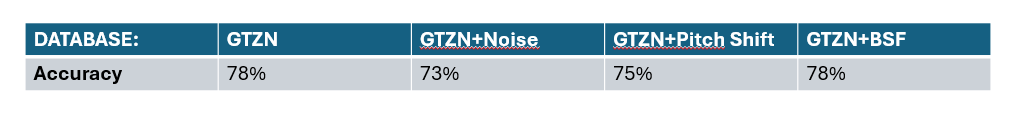